In [2]:
import uproot
import h5py
import numpy as np
import awkward as ak
import vector
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from tqdm import tqdm

In [3]:
base =  uproot.open("4top_parton_CPstudy.root") 
tree_even = base['CP_even']
tree_odd = base['CP_odd']




In [4]:
tree_even.keys()
#np.min(ak.num(tree['CP_even']['t_pt'].array(), axis = 1))

['nt_pt',
 't_pt',
 'nt_eta',
 't_eta',
 'nt_phi',
 't_phi',
 'nt_e',
 't_e',
 'ntbar_pt',
 'tbar_pt',
 'ntbar_eta',
 'tbar_eta',
 'ntbar_phi',
 'tbar_phi',
 'ntbar_e',
 'tbar_e']

In [5]:
def create_4_vectors(tree, particle):
    # creates a 4 vector for a given particle form a given tree (i.e t_even 4 vector)
    # first finds the max length in case padding is needed. This isn't needed for this file, but included for completeness
    max_len = np.max(ak.num(tree[f'{particle}_pt'].array(), axis = 1))
    names = ['pt', 'eta', 'phi', 'e']
    array = []
    for name in names:
        values = tree[f'{particle}_{name}'].array()
        padded = ak.pad_none(values, max_len, axis=1)
        padded = ak.fill_none(padded, 0)
        array.append(padded)
    
    vector_array = []
    for i in range(max_len):
        vector_array.append(vector.zip({param:array[j][:,i] for j, param in enumerate(names)})) # each element in vector array is another top quark
    
    return vector_array


def construct_array(t_even, tbar_even):
    # finds differences of values for each pair of t tbar
    dic = {'rapidity':[], 'phi':[], 'R':[]}
    array = 0
    for i in range(2):
        for j in range(2):
            d_rapidity = t_even[i].rapidity - tbar_even[j].rapidity
            d_R =  t_even[i].deltaR(tbar_even[j])
            d_phi = t_even[i].deltaphi(tbar_even[j])
            dic['rapidity'].append(d_rapidity)
            dic['phi'].append(d_phi)
            dic['R'].append(d_R)
    return dic

def b2(vector1, vector2):
    numerator = vector1.py * vector2.py+ vector1.px * vector2.px
    return numerator/(vector1.p * vector2.p)

def b4(vector1, vector2):
    return vector1.pz*vector2.pz/(vector1.p * vector2.p)


In [6]:
def form_training_data(base, even_odd):
    # packages all the parameters into an h5 file
    # we can then select the parameters we want in the training program
    # save a seperate file for cp odd and cp even
    # note that all that have no label of tt or tbar tbar are ttbar



    tree = base[f'CP_{even_odd}']
    t = create_4_vectors(tree, 't')
    tbar = create_4_vectors(tree, 'tbar')


    
    tt = t[0] + t[1] #for eta and invariant mass, rapidity
    tbartbar = tbar[0] + tbar[1] # for eta and invariant mass, rapidity
    tttt = tt + tbartbar
    ttbars = [t[0] + tbar[0],
                t[0] + tbar[1],
                t[1] + tbar[0],
                t[1] + tbar[1]
                ]
    # each combination of t and tbar
    
    dic = {}


    # # if not explicitly mentioned, the variable is for the ttbar system
    # # the order is the same as the images sent on whatsapp
    dic['tttt_m'] = tttt.m
    dic['tt_m'] = tt.m
    dic['tbartbar_m'] = tbartbar.m
    dic['greatest_mass']  = np.max([i.m for i in ttbars], axis = 0)

    dic['tt_eta'] = tt.eta
    dic['tbartbar_eta'] = tbartbar.eta
    dic['greatest_eta']  = np.max([i.eta for i in ttbars], axis = 0)
    dic['average_eta'] = np.mean([i.eta for i in ttbars], axis = 0)
    dic['min_eta'] = np.min([i.eta for i in ttbars], axis = 0)


    differences = construct_array(t, tbar)

    dic['tt_rapidity'] = np.abs(t[0].rapidity - t[1].rapidity)
    dic['tbartbar_rapidity'] = np.abs(tbar[0].rapidity - tbar[1].rapidity)
    dic['greatest_rapidity']  = np.max(differences['rapidity'], axis = 0)
    dic['average_rapidity'] = np.mean(differences['rapidity'], axis = 0)
    dic['min_rapidity'] = np.min(differences['rapidity'], axis = 0)

    dic['tt_phi'] = np.abs(t[0].phi - t[1].phi)
    dic['tbartbar_phi'] = np.abs(tbar[0].phi - tbar[1].phi)
    dic['greatest_phi']  = np.max(differences['phi'], axis = 0)
    dic['average_phi'] = np.mean(differences['phi'], axis = 0)
    dic['min_phi'] = np.min(differences['phi'], axis = 0)

    dic['tt_R'] = t[0].deltaR(t[1])
    dic['tbartbar_R'] = tbar[0].deltaR(tbar[1])
    dic['greatest_R']  = np.max(differences['R'], axis = 0)
    dic['average_R'] = np.mean(differences['R'], axis = 0)
    dic['min_R'] = np.min(differences['R'], axis = 0)
    dic['overall_min_R'] = np.min([dic['tt_R'], dic['tbartbar_R'], dic['min_R']], axis = 0)

    dic['tt_pt'] = tt.pt
    dic['tbartbar_pt'] = tbartbar.pt
    dic['greatest_pt']  = np.max([i.pt for i in ttbars], axis = 0)
    min_indices = np.argmin(differences['rapidity'], axis=0)
    dic['ttbar_pt_smallest_dR'] = ttbars[0].pt*(min_indices == 0) + ttbars[1].pt*(min_indices == 1) + ttbars[2].pt*(min_indices == 2) + ttbars[3].pt*(min_indices == 3)

    dic['HT'] = t[0].pt + t[1].pt + tbar[0].pt + tbar[1].pt

    dic['overall_max_pt'] = np.max([i.pt for i in t + tbar], axis = 0)
    dic['overall_min_pt'] = np.min([i.pt for i in t + tbar], axis = 0)
    dic['overall_diff_pt'] = dic['overall_max_pt'] - dic['overall_min_pt']

    dic['tt_alignment'] = b2(t[0], t[1])
    dic['tbartbar_alignment'] = b2(tbar[0], tbar[1])
    b2s = np.stack((b2(t[0],tbar[0]), b2(t[0],tbar[1]), b2(t[1],tbar[0]), b2(t[1],tbar[1])), axis = 1)
    b4s = np.stack((b4(t[0],tbar[0]), b4(t[0],tbar[1]), b4(t[1],tbar[0]), b4(t[1],tbar[1])), axis = 1)
    max_ttbar_pt_index = np.argmax([i.pt for i in ttbars], axis = 0)

    stacking = np.stack([(max_ttbar_pt_index == i) for i in range(4)], axis = 1)
    dic['leading_pt_b2'] = np.sum(stacking * b2s, axis = 1)
    dic['leading_pt_b4'] = np.sum(stacking * b4s, axis = 1)

    max_t_pt_index = np.argmax([i.pt for i in t], axis = 0)
    max_t_pt_differences = differences['R'][0:2] * (max_t_pt_index == 0) + differences['R'][2:] * (max_t_pt_index == 1) # define closest as smallest delta R
    final_indicies = 2*max_t_pt_index+np.argmin(max_t_pt_differences, axis = 0)
    stacking = np.stack([(final_indicies == i) for i in range(4)], axis = 1)
    dic['leading_tpt_ttbar_b2'] = np.sum(stacking * b2s, axis = 1)
    dic['leading_tpt_ttbar_b4'] = np.sum(stacking * b4s, axis = 1)

    max_tbar_pt_index = np.argmax([i.pt for i in tbar], axis = 0)
    max_tbar_pt_differences = differences['R'][0::2] * (max_tbar_pt_index == 0) + differences['R'][1::2] * (max_tbar_pt_index == 1) # define closest as smallest delta R
    final_indicies = 2*np.argmin(max_tbar_pt_differences, axis = 0) + max_tbar_pt_index
    stacking = np.stack([(final_indicies == i) for i in range(4)], axis = 1)
    dic['leading_tbarpt_ttbar_b2'] = np.sum(stacking * b2s, axis = 1)
    dic['leading_tbarpt_ttbar_b4'] = np.sum(stacking * b4s, axis = 1)
    



    # 31 in total inputs (should make it 32 and then its a nice round number)
    # is this too many? could begin with a smaller ammount and then add some

    h5_file = h5py.File(f"tttt_{even_odd}.h5", 'w')
    group = h5_file.create_group('Objects')
    for key in dic.keys():
        group.create_dataset(key, data=dic[key])
    
    h5_file.close()
    return dic







In [7]:
dic_even = form_training_data(base, 'even')
dic_odd = form_training_data(base, 'odd')


- first do for top vs top
- then for topbar vs topbar
- then find for leading pt ttbar
- find for leading pt_top and nearest tbar (how is nearest defined?)

In [8]:

tree = base['CP_even']
t = create_4_vectors(tree, 't')
tbar = create_4_vectors(tree, 'tbar')



tt = t[0] + t[1] #for eta and invariant mass, rapidity
tbartbar = tbar[0] + tbar[1] # for eta and invariant mass, rapidity
tttt = tt + tbartbar
ttbars = [t[0] + tbar[0],
            t[0] + tbar[1],
            t[1] + tbar[0],
            t[1] + tbar[1]
            ]
# each combination of t and tbar

dic = {}

differences = construct_array(t, tbar)

In [9]:
index = np.argmax([i.pt for i in ttbars], axis = 0)
stacking = np.stack([(index == i) for i in range(4)], axis = 1)
# leading_pt_ttbar = (np.stack((ttbars[0].px, ttbars[0].py, ttbars[0].pz, ttbars[0].p), axis = 1) * (index == 0)
#                 + np.stack((ttbars[1].px, ttbars[1].py, ttbars[1].pz, ttbars[1].p), axis = 1) * (index == 1)
#                 + np.stack((ttbars[2].px, ttbars[2].py, ttbars[2].pz, ttbars[2].p), axis = 1) * (index == 2)
#                 + np.stack((ttbars[3].px, ttbars[3].py, ttbars[3].pz, ttbars[3].p), axis = 1) * (index == 3))
# E = np.sum(stacking * np.stack([i.E for i in ttbars], axis = 1), axis = 1)
# b_x = np.sum(stacking * np.stack([i.px for i in ttbars], axis = 1), axis = 1)/E
# b_y = np.sum(stacking * np.stack([i.py for i in ttbars], axis = 1), axis = 1)/E
# b_z = np.sum(stacking * np.stack([i.pz for i in ttbars], axis = 1), axis = 1)/E
# boost_vector = vector.obj(px=b_x, py=b_y, pz=b_z)
# ttbars[0].boost(boost_vector)





# want to convert to 



# boost_vector = vector.obj(px=, py=beta_y, pz=beta_z)


In [10]:
3-2

1

find momentum, energy of leading pt ttbar
first get restframe of leading pt ttbar 
define unit vector funciton


In [11]:
def plot_variable(variables):
    # plots all the variables
    for variable in variables:
        high_limit = np.max(np.concatenate([dic_even[variable],dic_odd[variable]]))
        low_limit = min(0,np.min(np.concatenate([dic_even[variable],dic_odd[variable]])))
        hep.style.use(hep.style.ATLAS)
        hist1 = bh.Histogram(bh.axis.Regular(100, low_limit, high_limit))
        hist2 = bh.Histogram(bh.axis.Regular(100, low_limit, high_limit))
        hist1.fill(dic_even[variable])
        hist2.fill(dic_odd[variable])


        hep.histplot([hist1/hist1.sum(), hist2/hist2.sum()], label = ['even', 'odd'])
        #plt.xlabel('pt [Gev/c]')
        plt.ylabel('Normalized Frequency')
        plt.title(f'{variable} for odd and even')
        plt.legend()
        plt.show()

In [13]:
len(dic_even.keys())

41

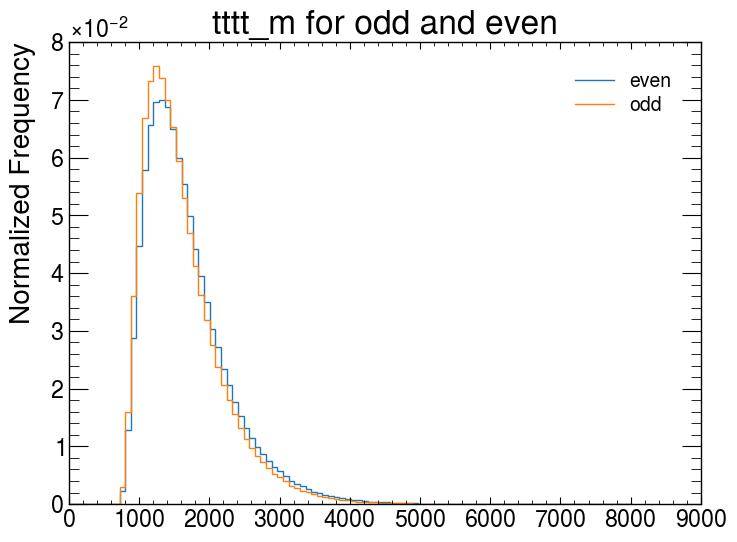

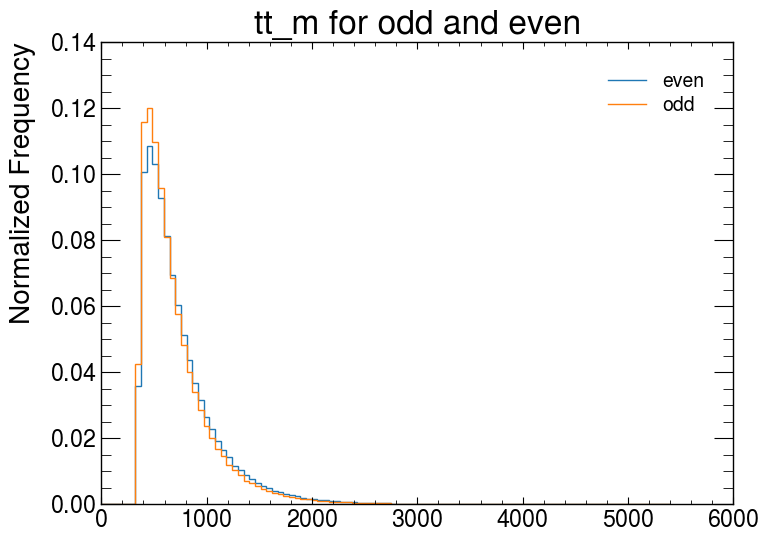

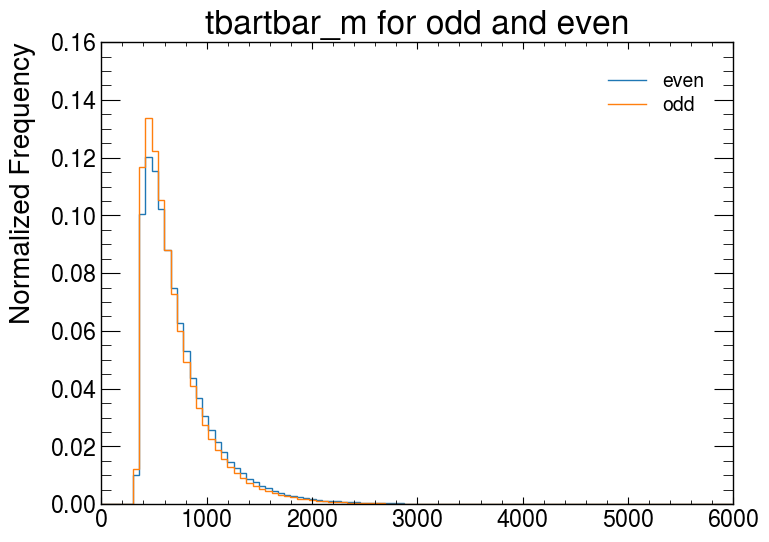

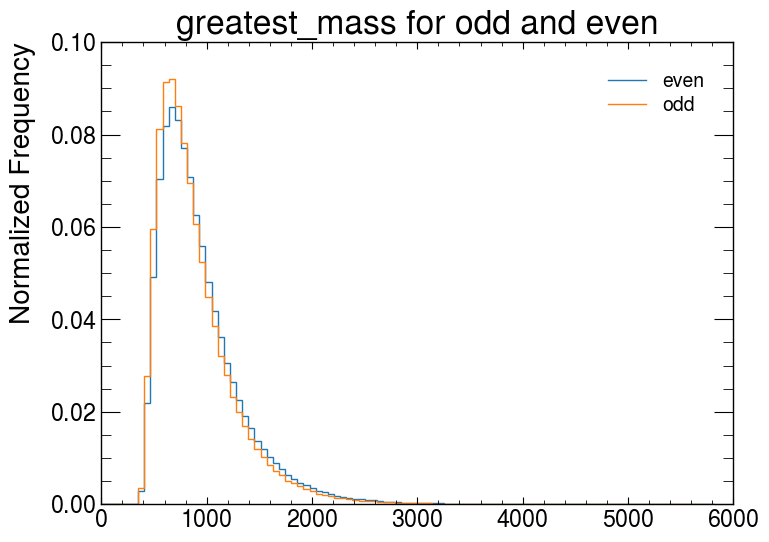

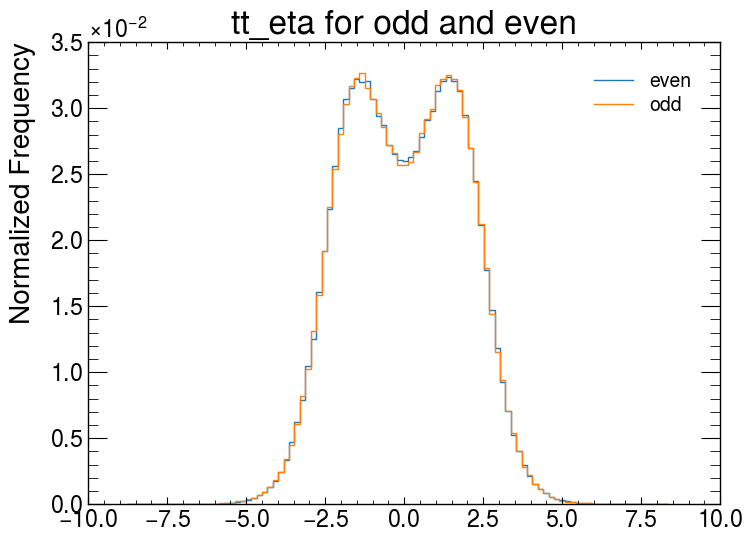

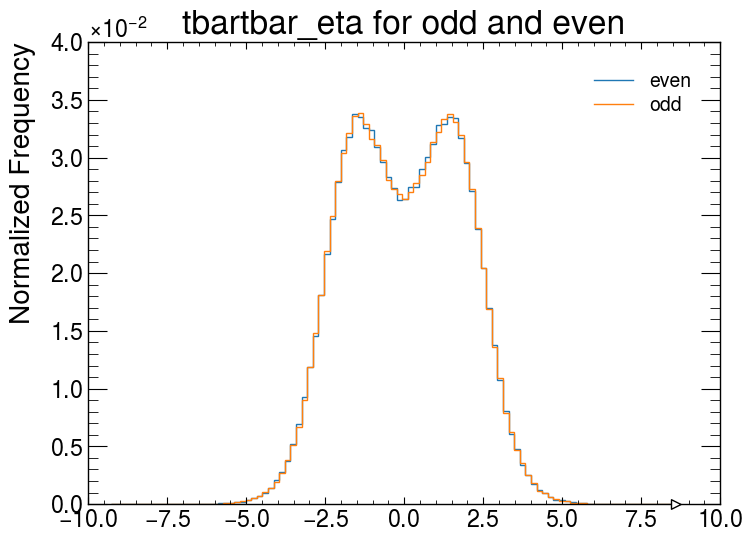

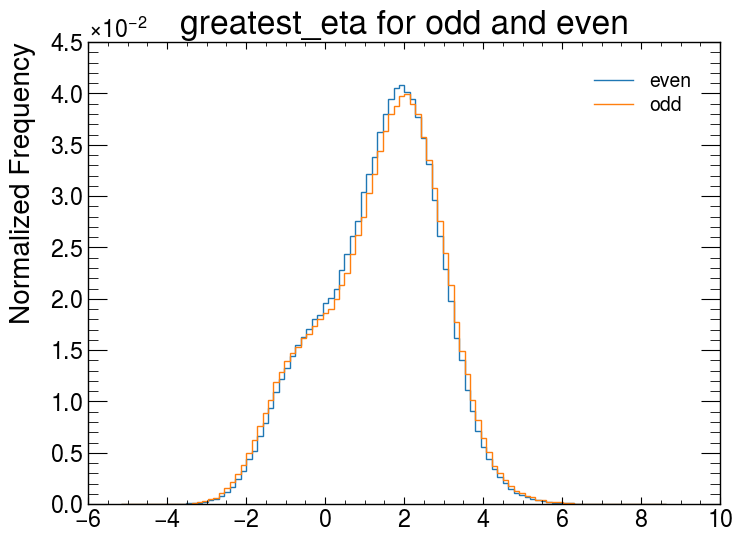

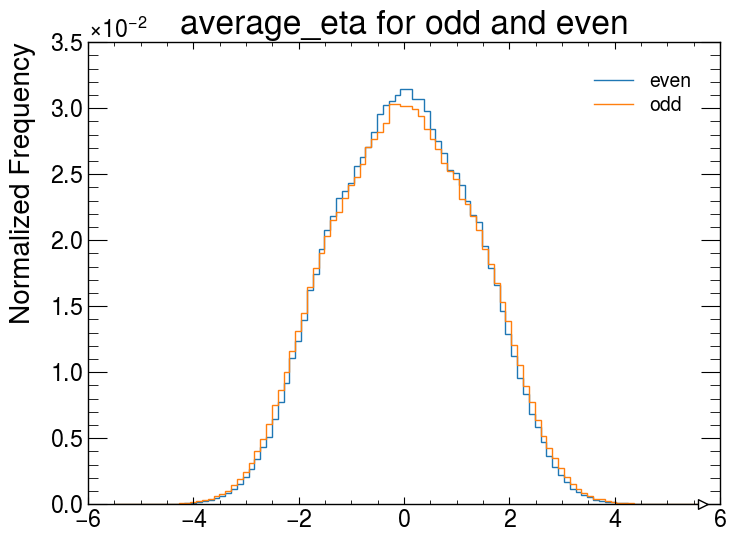

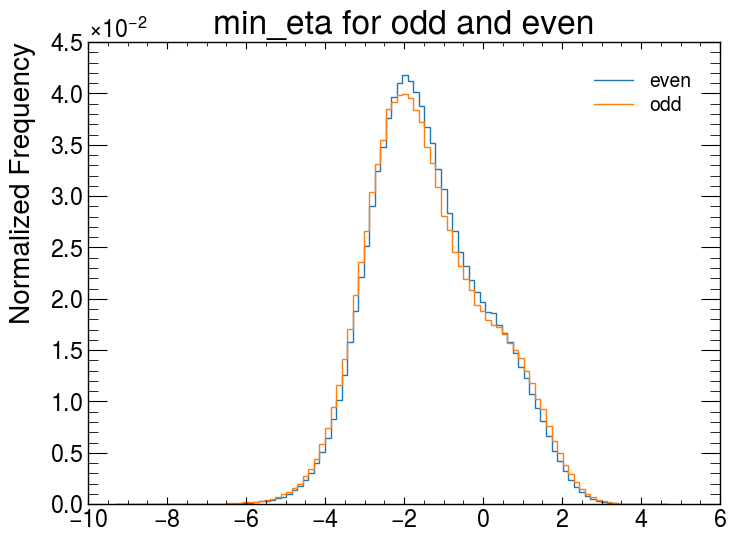

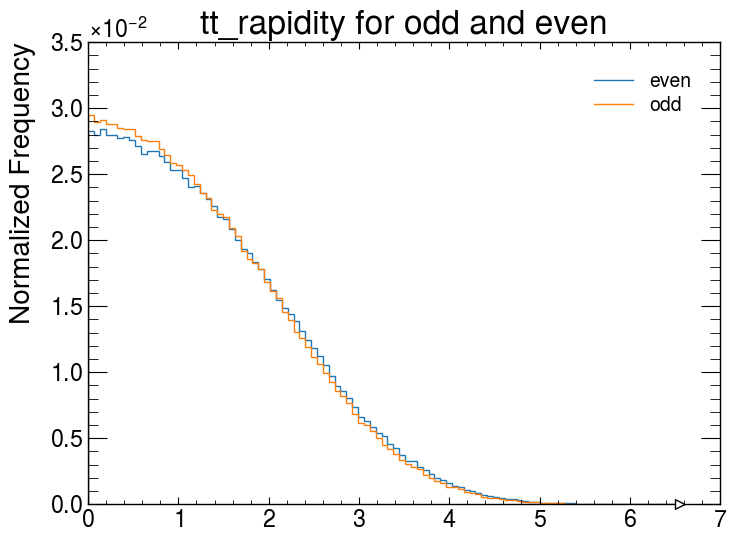

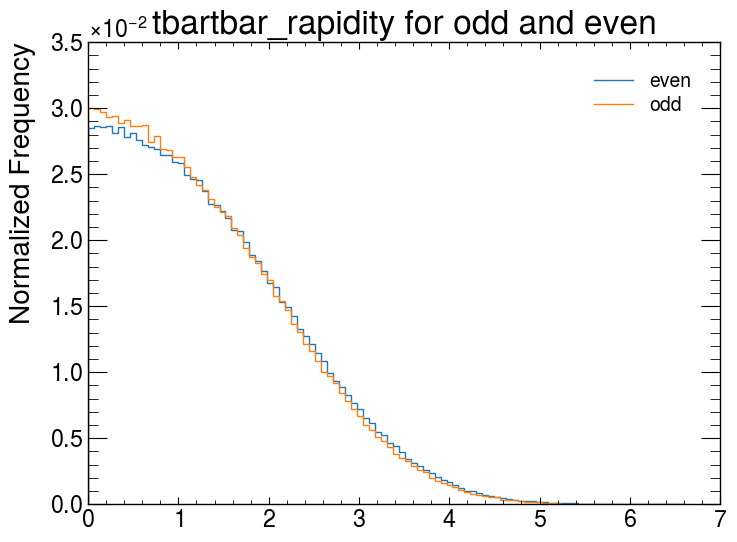

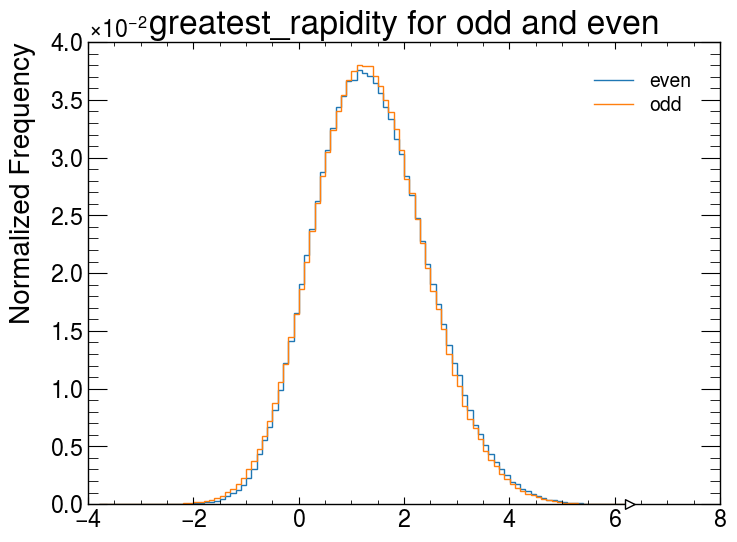

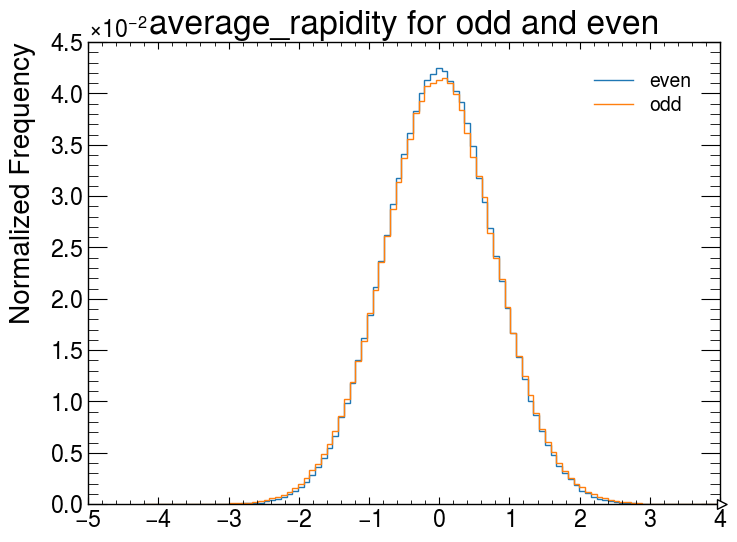

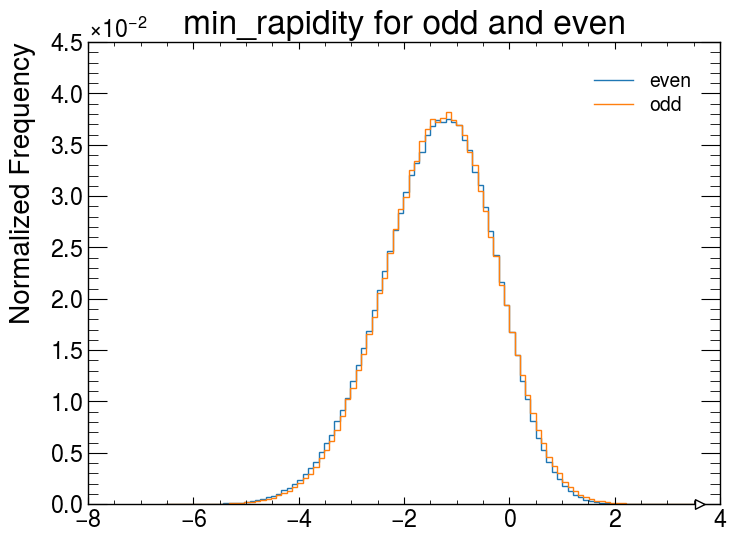

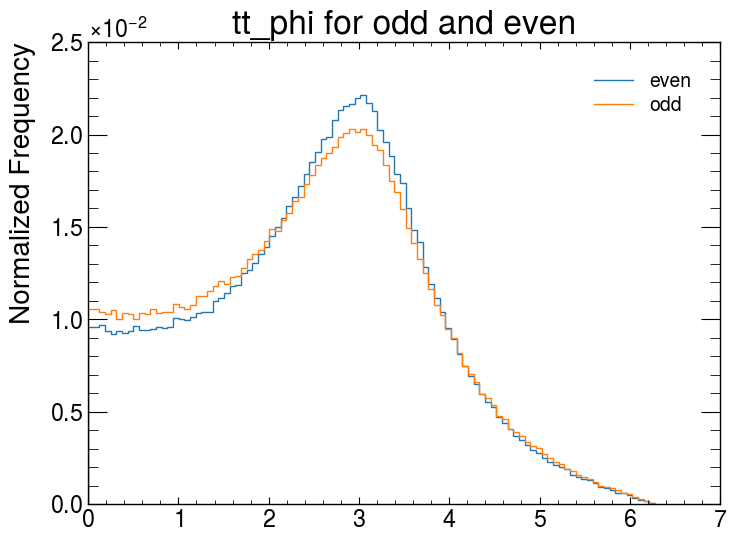

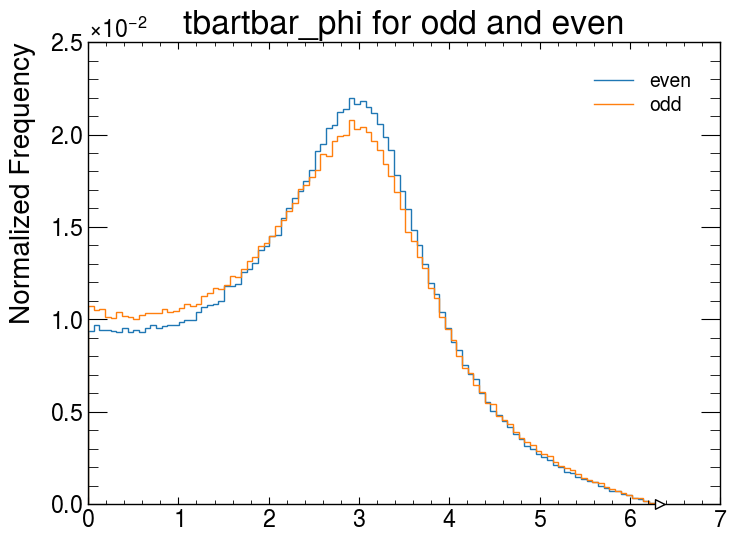

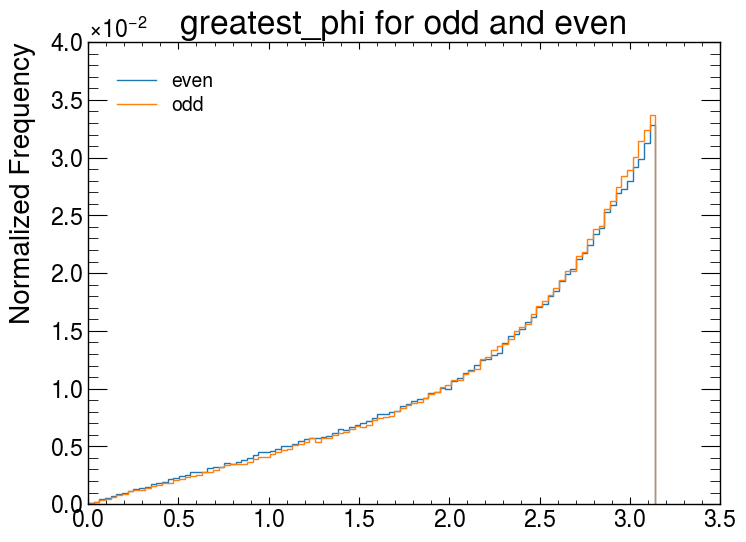

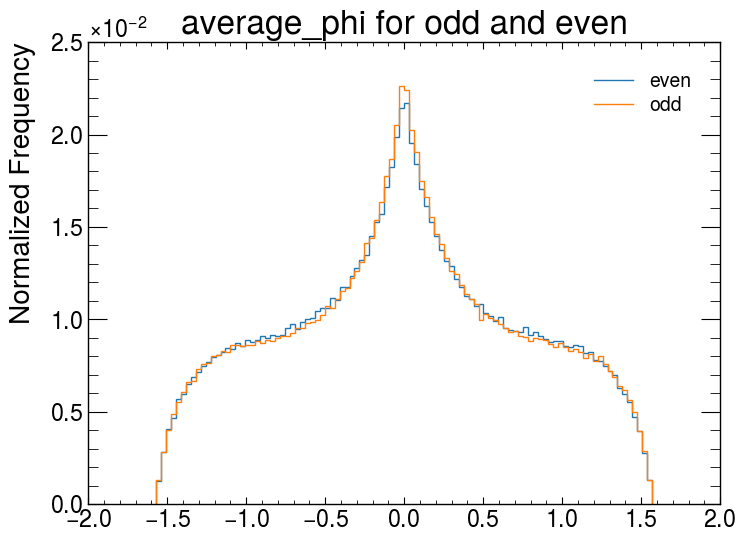

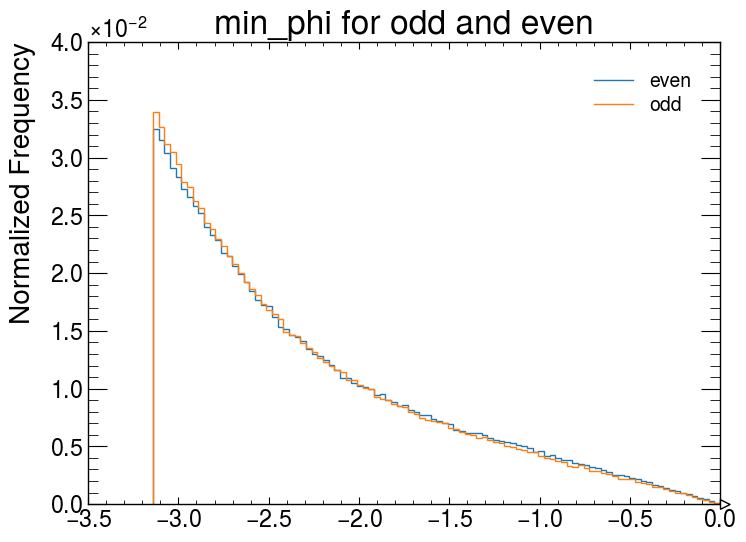

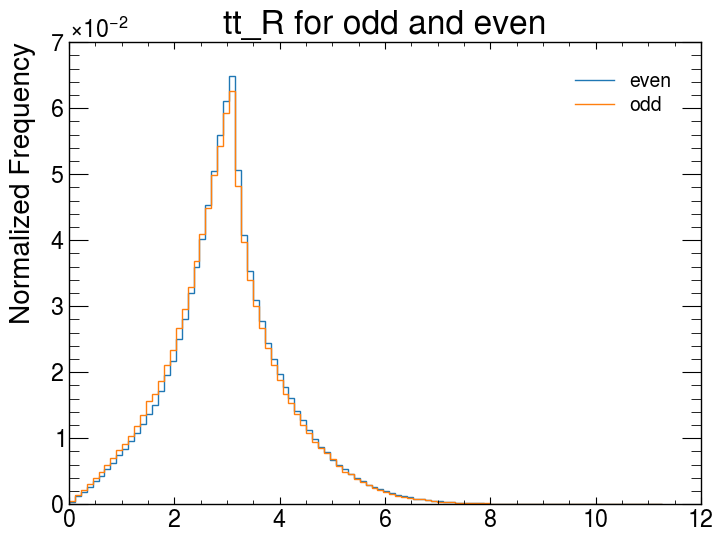

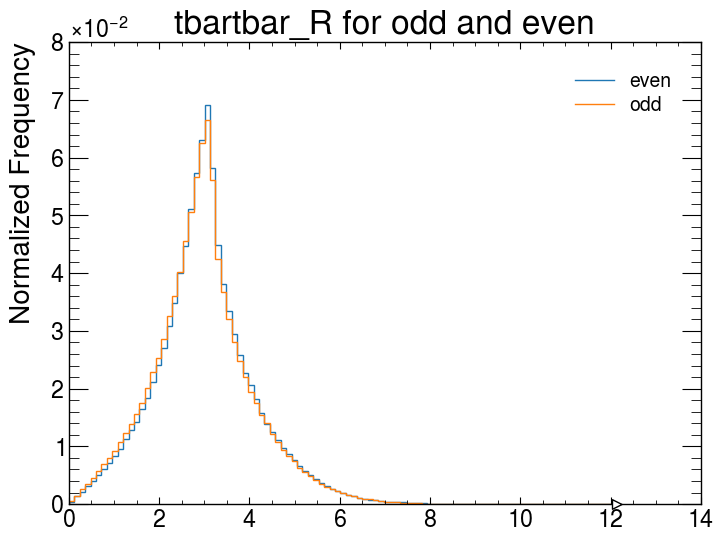

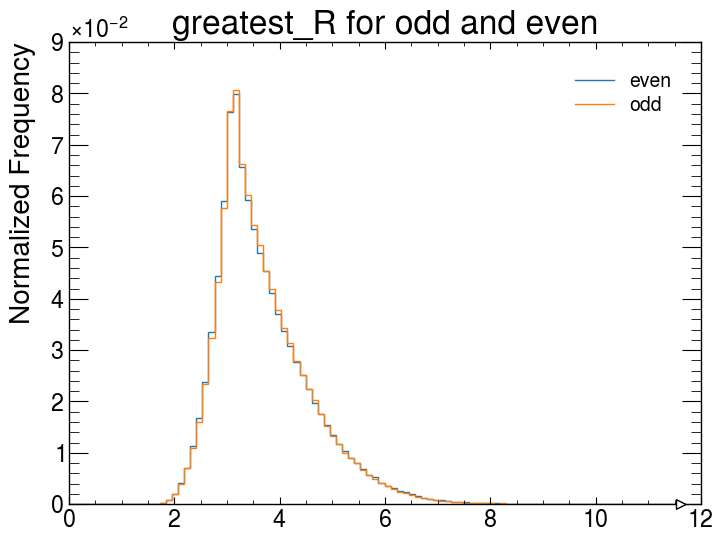

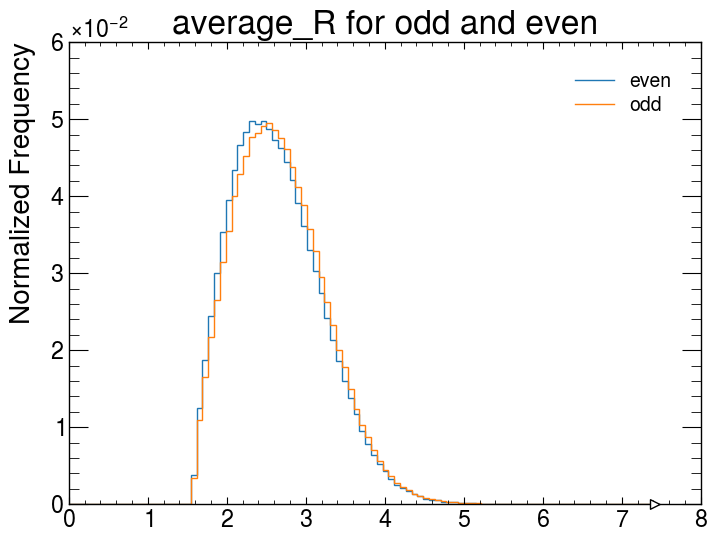

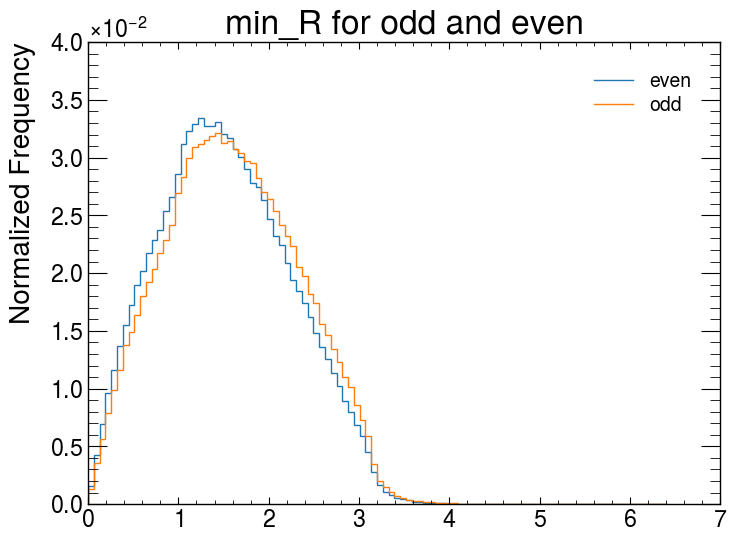

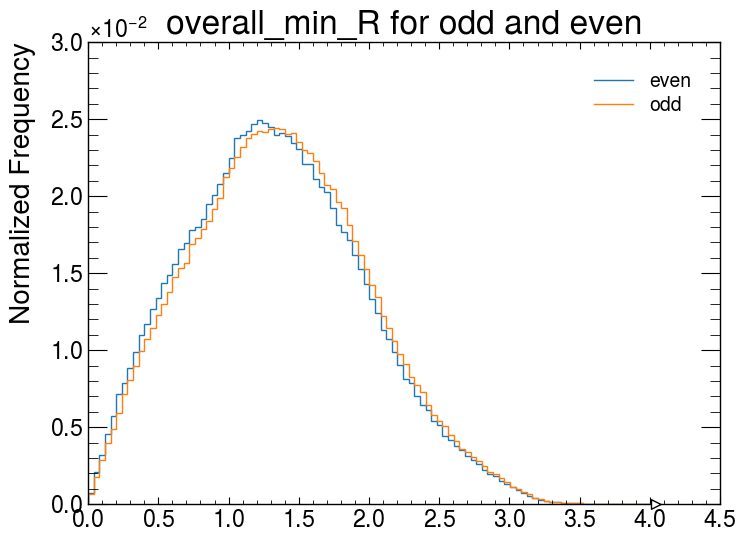

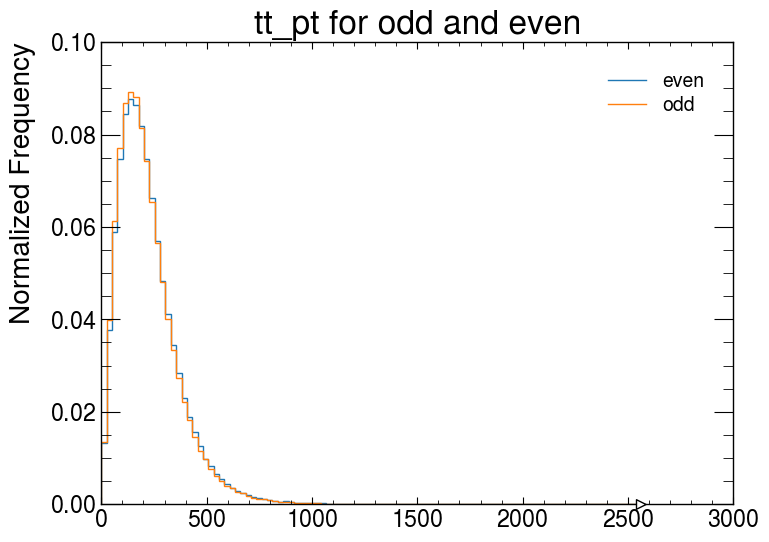

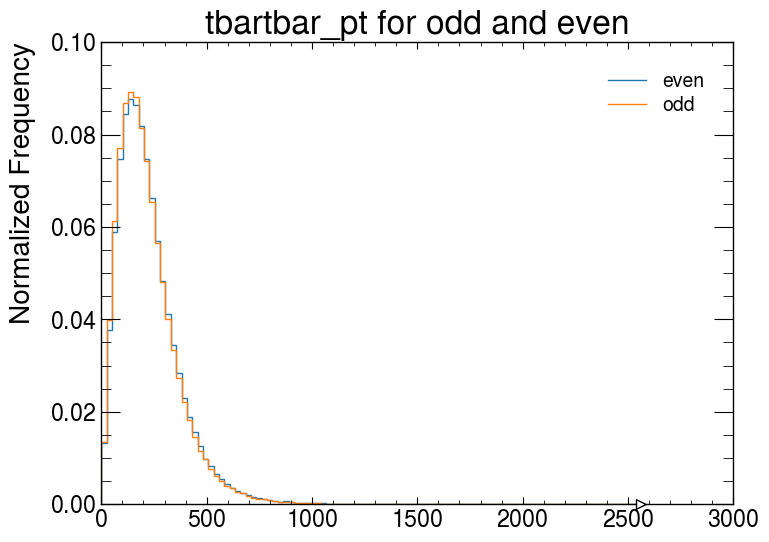

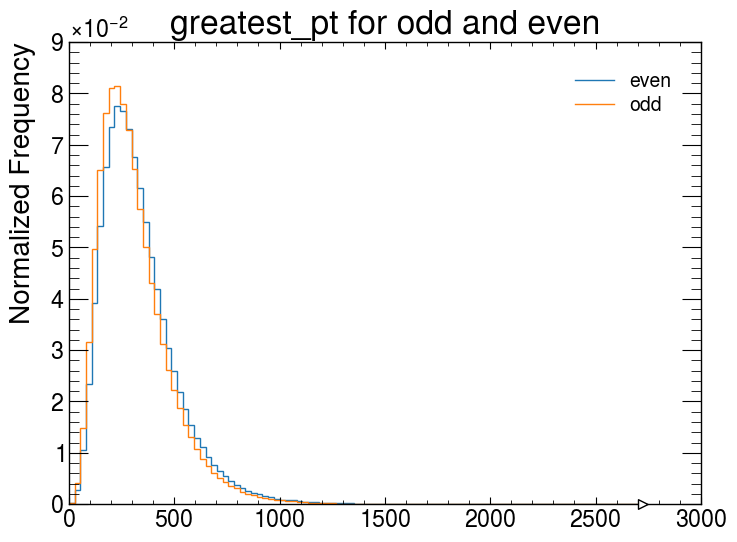

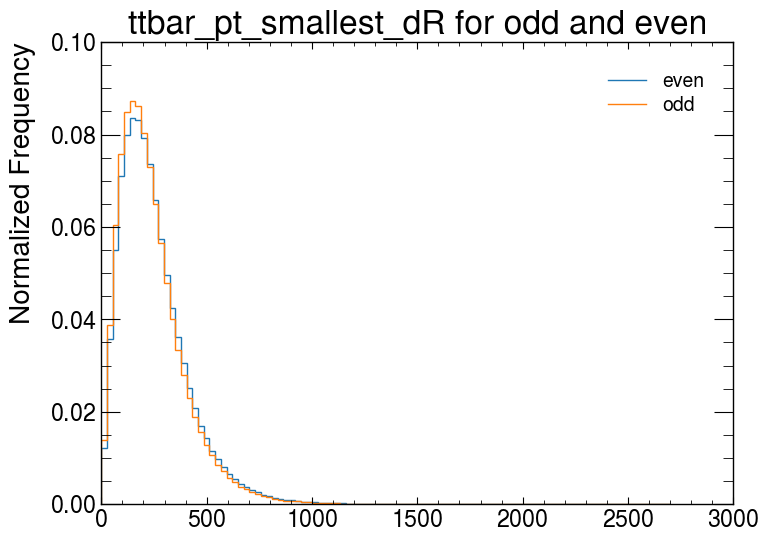

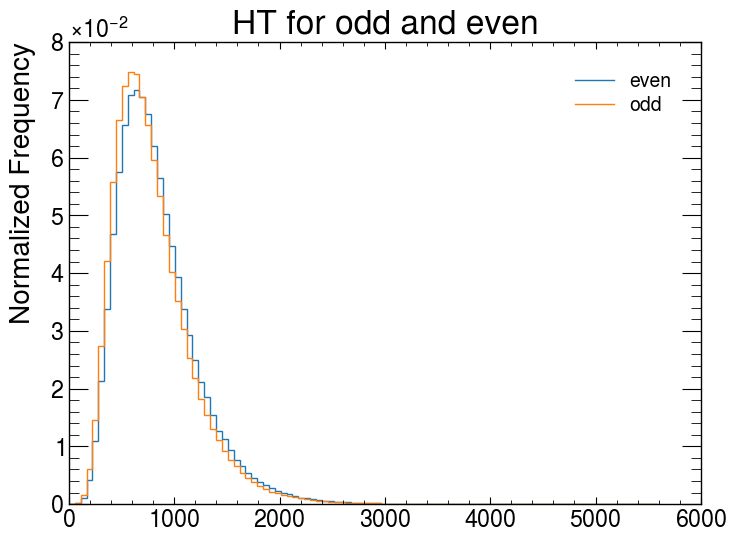

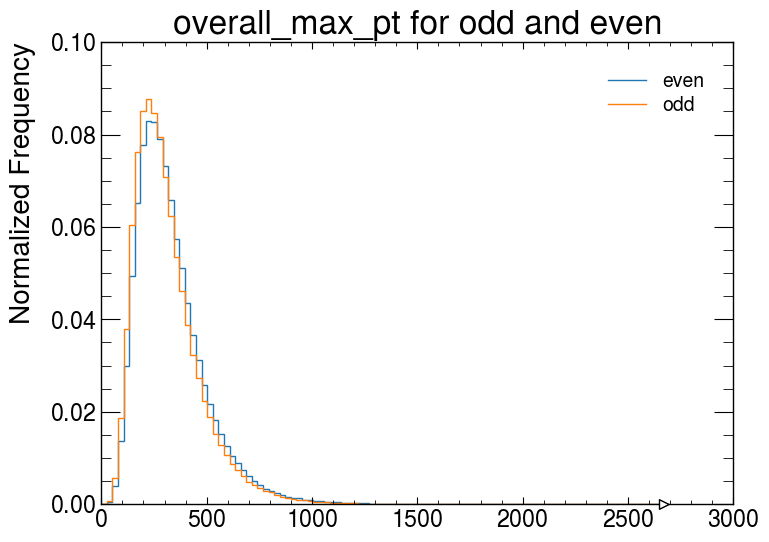

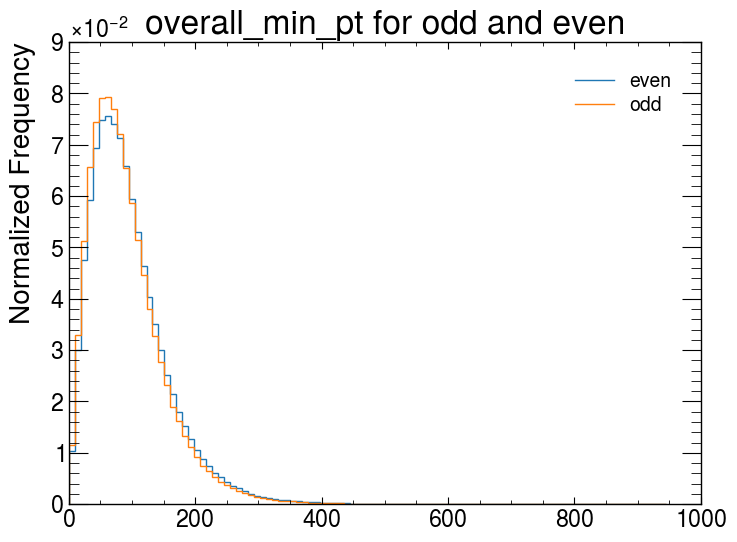

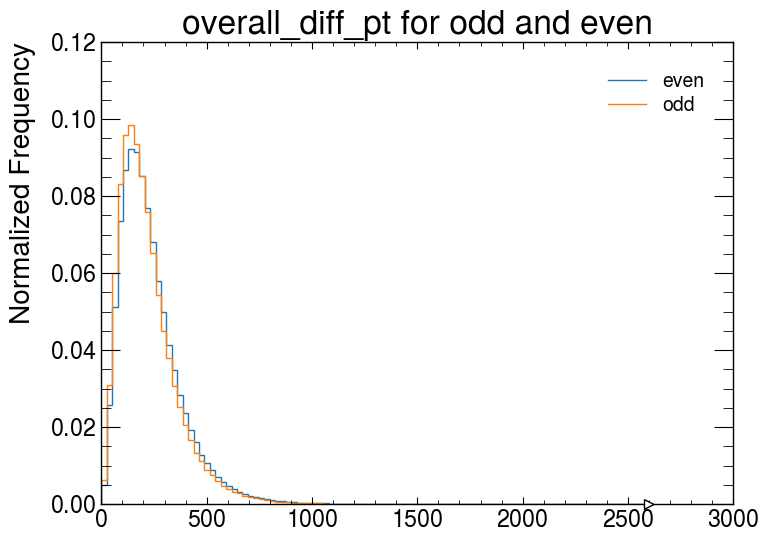

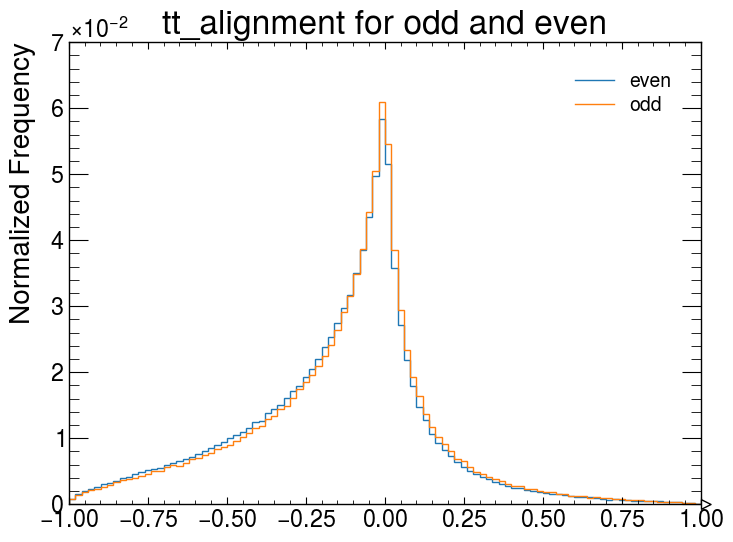

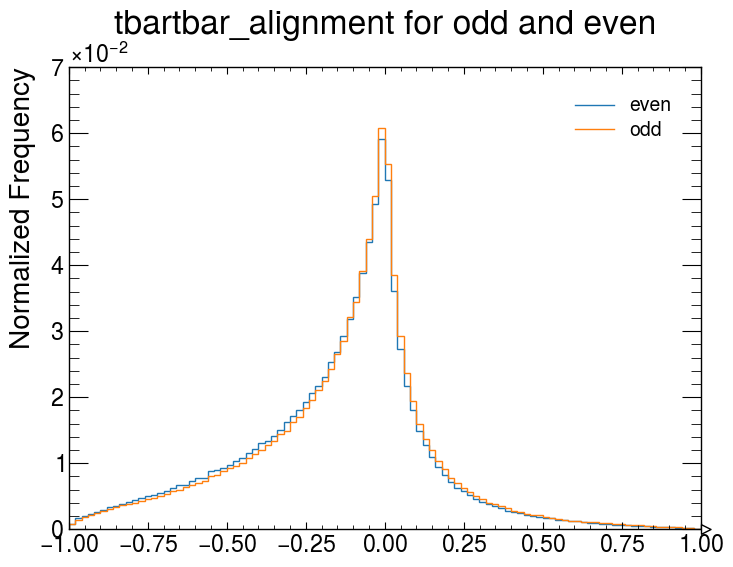

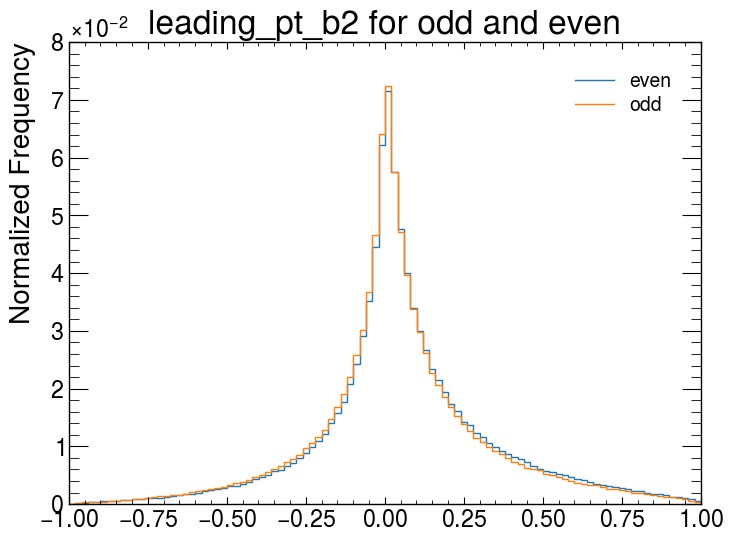

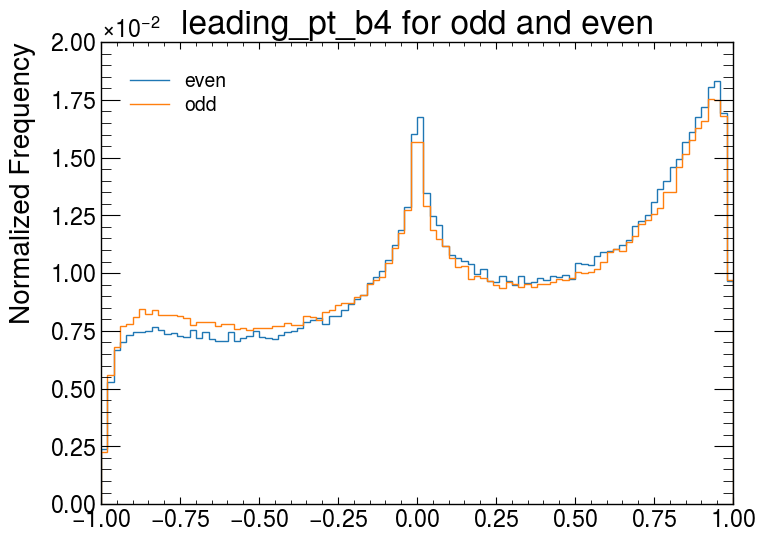

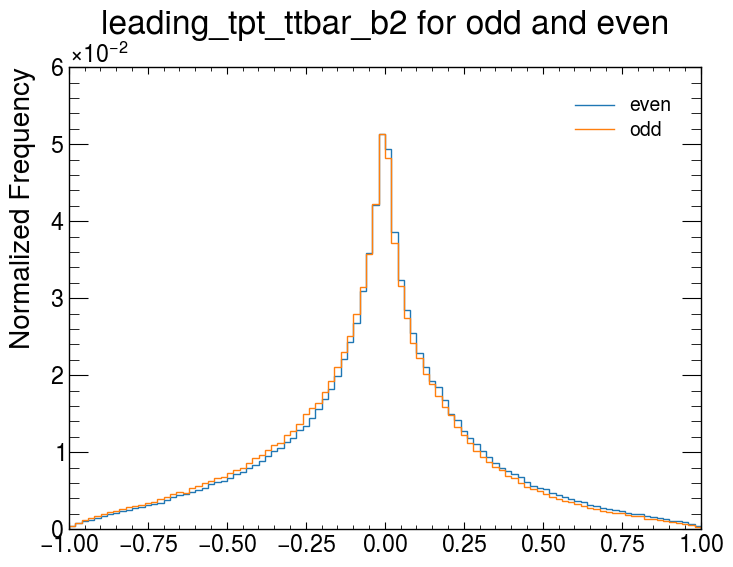

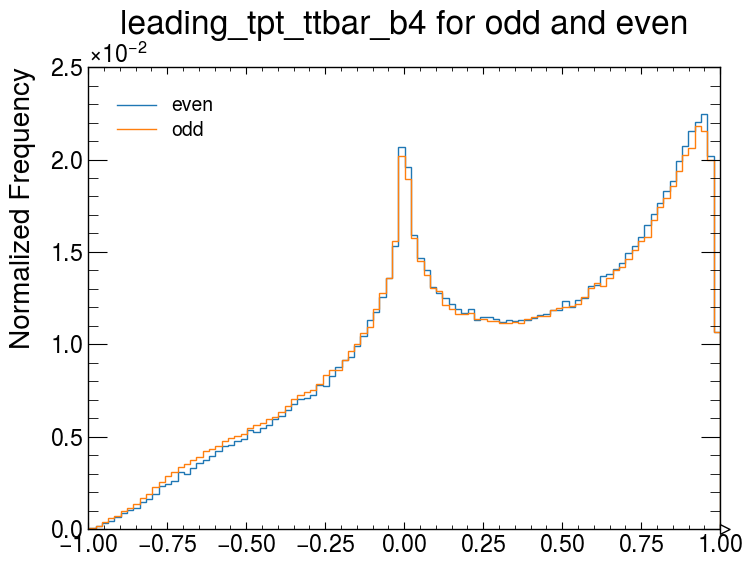

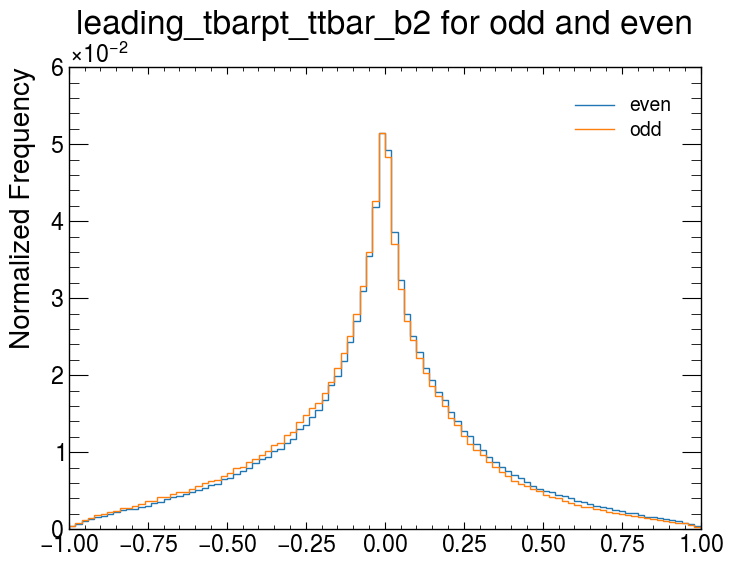

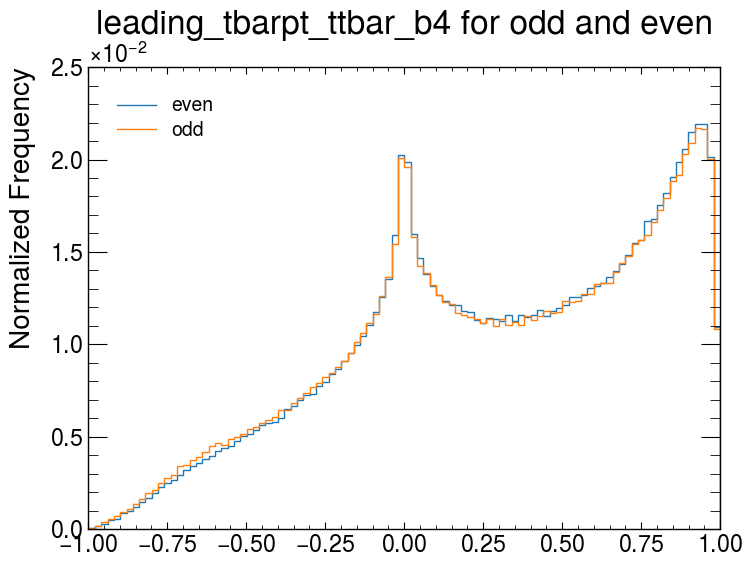

In [12]:
plot_variable(dic_even.keys()) # this one plots all 33 which is useful for comparison 
#plot_variable(['leading_tpt_ttbar_b2', 'leading_tbarpt_ttbar_b2', 'leading_tpt_ttbar_b4', 'leading_tbarpt_ttbar_b4'])

what is the dic['tbartbar_pt'][np.argmin(differences['rapidity'], axis = 0)]  observable doing
- finding the index of each of the min in rapidity
- finding value at index 0, 1, 2, 3 of tbartbar
- but why is this a good indicator of even or odd?
- model can learn what the possible values are for even, and what it is for odd.
- i am therefore back to square 1 :(